![PUC-Rio header](http://www.puc-rio.br/sobrepuc/admin/vrd/brasao/download/ass_horizpb_com4.jpg)

# Programming the WFG multi-objective problem toolkit in Python

## César Revelo and [Luis Martí](http://lmarti.com)
### Laboratory of Applied Intelligence and Robotics
### [Department of Electrical Engineering](http://www.ele.puc-rio.br)
### [Pontifícia Universidade Católica do Rio de Janeiro](http://www.puc-rio.br)

This notebook is meant to test and illustrate our implementation of the WFG problems.

Papers:

* Lucas Bradstreet, Luigi Barone, Lyndon While, Simon Huband, and Phil Hingston. Use of the WFG Toolkit and PISA for Comparison of Multi-objective Evolutionary Algorithms. 2007 IEEE Symposium on Computational Intelligence in Multi-criteria Decision-making. IEEE MCDM 2007, pages 382-389. IEEE, April 2007. [download](http://www.wfg.csse.uwa.edu.au/publications/WFG2007b.pdf)

* Simon Huband, Phil Hingston, Luigi Barone, and Lyndon While. A Review of Multi-objective Test Problems and a Scalable Test Problem Toolkit. IEEE Transactions on Evolutionary Computation, volume 10, no 5, pages 477-506. IEEE, October 2006. [download](http://www.wfg.csse.uwa.edu.au/publications/WFG2006c.pdf)

* Simon Huband, Luigi Barone, Lyndon While, and Phil Hingston. A Scalable Multi-objective Test Problem Toolkit. 3rd International Conference on Evolutionary Multi-Criterion Optimization. EMO 2005, volume 3410 of Lecture Notes in Computer Science, pages 280-294. Springer-Verlag, March 2005.

Existing implementations:

* Walking Fish Group WFG toolkit project: http://www.wfg.csse.uwa.edu.au/toolkit/
* jMetal: http://jmetal.sourceforge.net/problems.html

<br/>
<div class="alert alert-info">
    <p>
    <span class="label label-primary">To be merged inside DEAP!</span>
    After we test that the problem are correctly implemented we plan to submit the code to the [DEAP](http://github.com/deap/DEAP) guys.
    </p>
 </div>

In [1]:
from deap import algorithms, base, benchmarks, tools, creator

In [2]:
import numpy as np
import pandas as pd
import array, random, os, matplotlib

In [3]:
import wfg

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
%config InlineBackend.figure_format = 'retina'

In [6]:
problems = {'wfg1': wfg.wfg1_problem_instance, 
            'wfg2': wfg.wfg2_problem_instance, 
            'wfg3': wfg.wfg3_problem_instance, 
            'wfg4': wfg.wfg4_problem_instance, 
            'wfg5': wfg.wfg5_problem_instance, 
            'wfg6': wfg.wfg6_problem_instance, 
            'wfg7': wfg.wfg7_problem_instance, 
            'wfg8': wfg.wfg8_problem_instance, 
            'wfg9': wfg.wfg9_problem_instance}

In [7]:
distance = 20                   # number of distance-related parameters(l) l==> {2, 4, 6,...} for WFG2 and WFG3
position = 4                    # number of position-related parameters(k) k==> {2(M-1), 3(M-1),...}
num_vars = distance + position      # number of problem variables

# Two objective problems

In [8]:
num_objs = 2                  # number of objectives(M) k+l >= M

In [11]:
for problem_name in sorted(problems):
    f, bounds, sol_f = problems[problem_name](distance, position, num_objs)
    print(problem_name, f((np.random.rand(24))))

wfg1 [1.0033002102363537, 4.7311399026593737]
wfg2 [0.66672561607997349, 4.642235775736463]
wfg3 [0.90147601020648571, 4.1533421174670035]
wfg4 [2.0504886209469206, 3.9423781793360653]
wfg5 [1.2604649277404947, 3.3793624680091785]
wfg6 [1.2075456785551273, 3.2858270726593974]
wfg7 [2.8672889559270236, 1.8940424642723945]
wfg8 [0.95621882059749597, 4.3635938849575133]
wfg9 [0.8819408382418727, 3.9945858834997905]


Let's compare the solutions produced by the `sol_f` functions with the Pareto fronts downloadable from http://jmetal.sourceforge.net/problems.html. Right now we are going to do it visually but we should compare the hypervolumes to be sure.

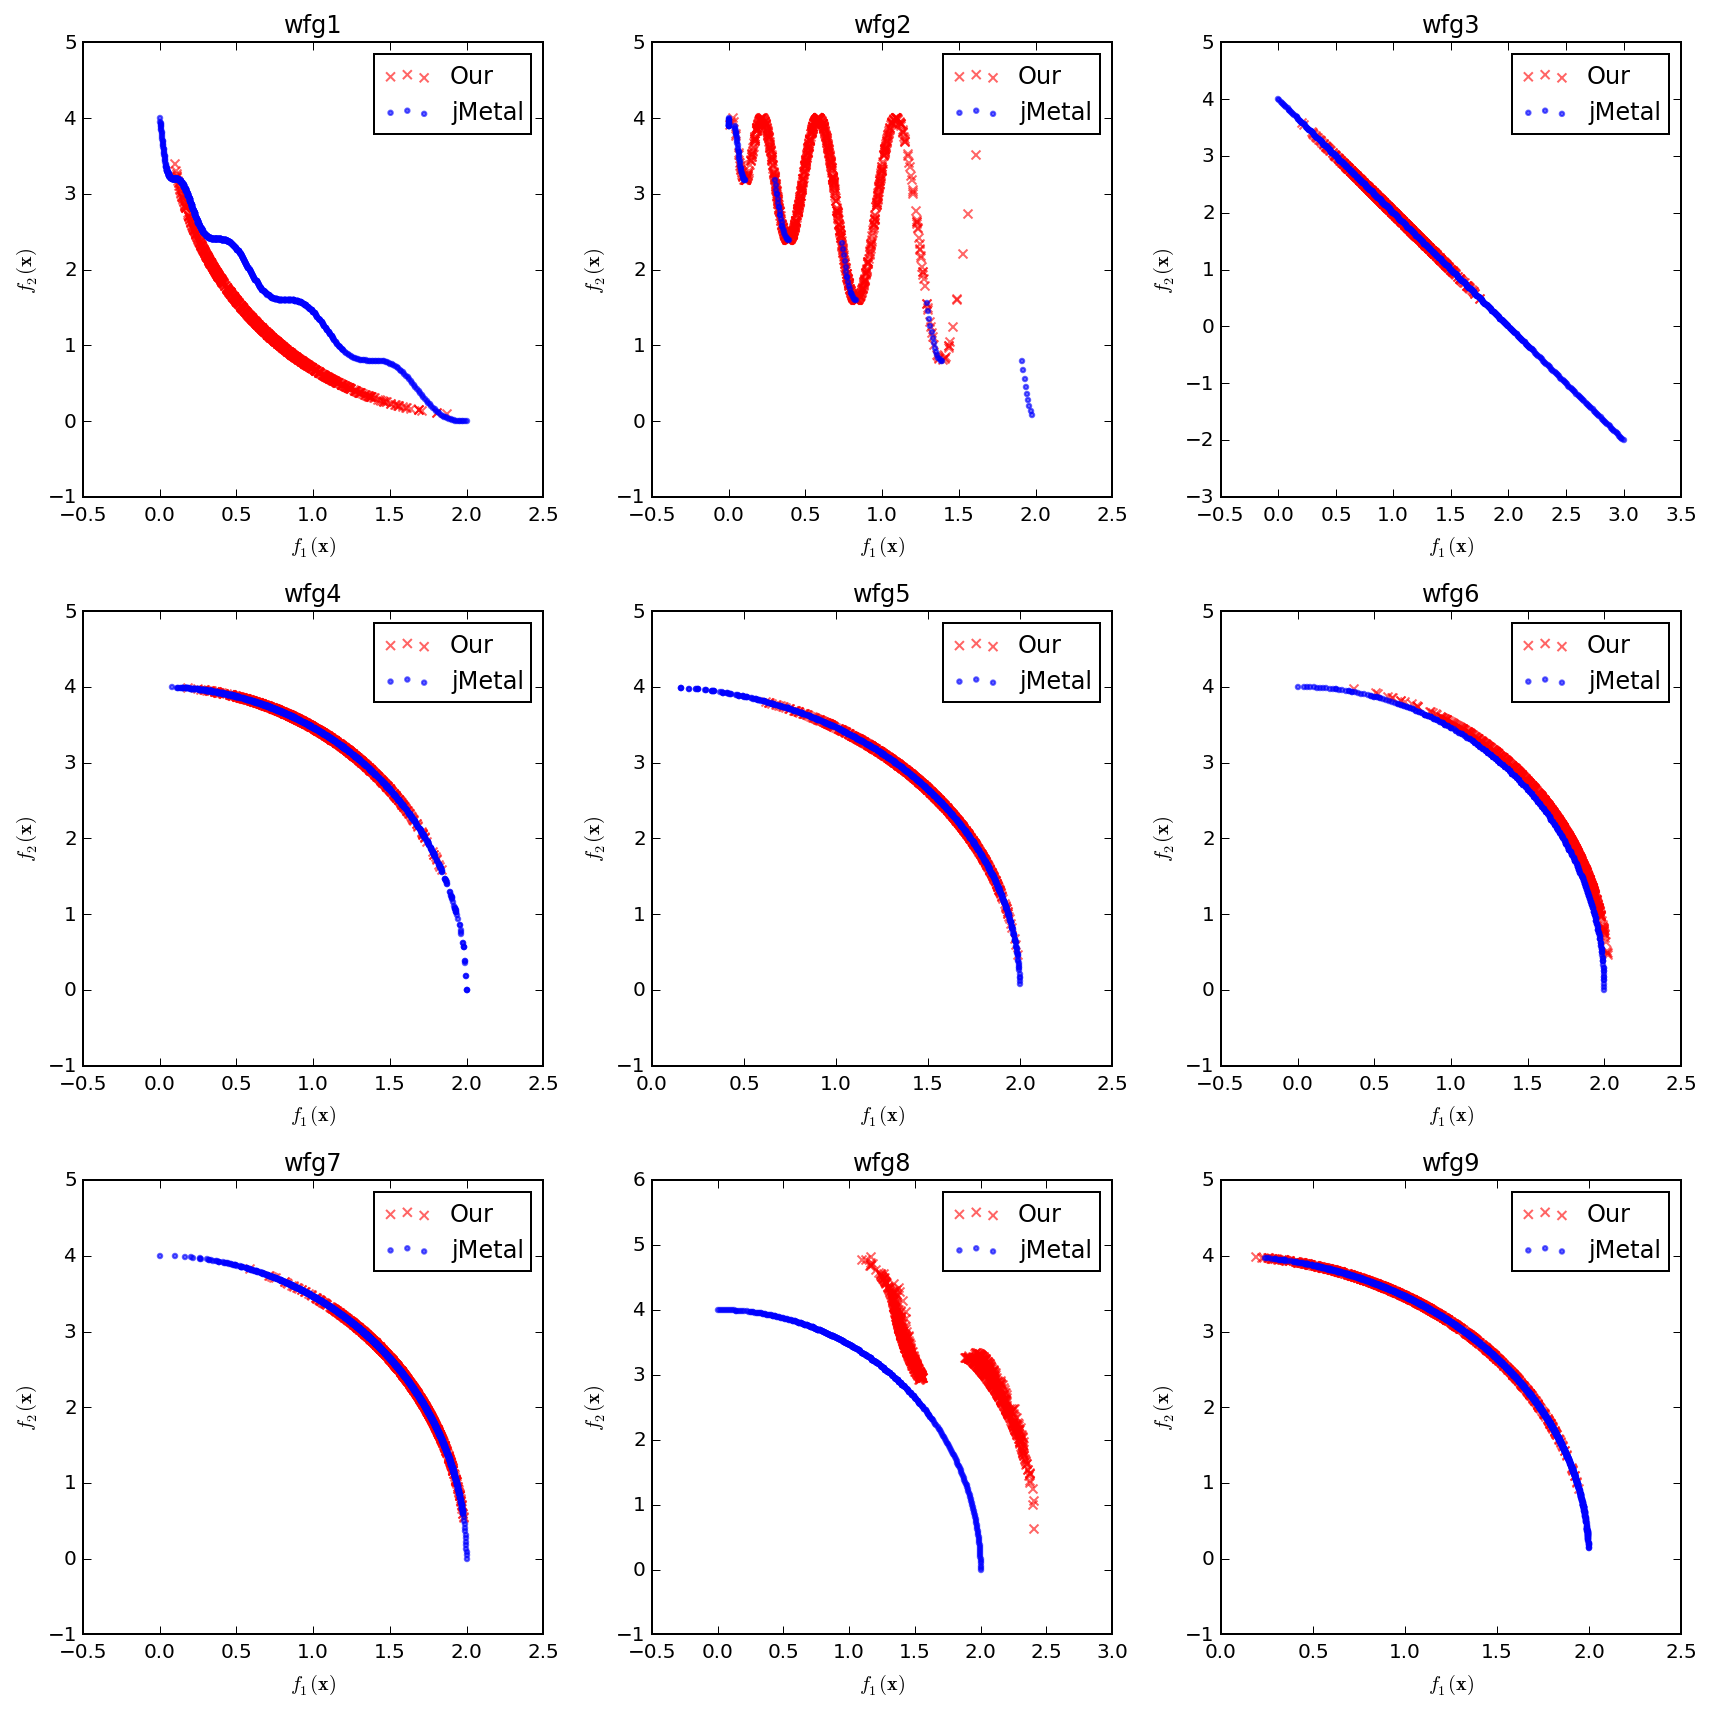

In [12]:
plt.figure(figsize=(4*(len(problems)//3),4*3))
for i, problem_name in enumerate(sorted(problems)):
    ax = plt.subplot(len(problems)//3, 3, i+1)
    f, (bound_low, bound_high), sol_f = problems[problem_name](distance, position, num_objs)
    
    opt = [f(sol_f()) for _ in range(1000)]

    df = pd.DataFrame(opt)
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, marker='x',color='r', alpha=0.6, label='Our')
    
    jm = pd.read_table('WFG.2D' + os.sep+ 'WFG'+ str(i+1)+'.2D.pf', sep=' ', header=None).dropna(axis=1)
    if i==1:
        jm = pd.read_table('WFG.2D' + os.sep+ 'WFG'+ str(i+1)+'.2D.pf', sep='\t', header=None).dropna(axis=1)
    
    ax.scatter(jm[jm.columns[0]].values, jm[jm.columns[1]].values, marker='.', color='b', alpha=0.6,label='jMetal')
    plt.legend()
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$')
    plt.title(problem_name)
plt.tight_layout()

We can now apply NSGA-II to the problem to see if we get correct results.

In [13]:
creator.create("FitnessMin2D", base.Fitness, weights=(-1.,-1.))
creator.create("Individual", array.array, typecode='d',fitness=creator.FitnessMin2D)

In [14]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [15]:
def nsga_ii_2d(toolbox):
    
    toolbox.register("attr_float", uniform, 
                     toolbox.bounds_low, toolbox.bounds_high,
                     num_vars)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, 
                     low=toolbox.bounds_low, up=toolbox.bounds_high, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, 
                     low=toolbox.bounds_low, up=toolbox.bounds_high, eta=20.0, indpb=1.0/num_vars)
    toolbox.register("select", tools.selNSGA2)
    
    toolbox.pop_size = 100
    toolbox.max_gen = 1000
    toolbox.mut_prob = 0.1
    
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    
    return algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, stats=None,
                                     ngen=toolbox.max_gen,verbose=False)

In [16]:
def run_nsga_ii_on_2d_problem(problem_name):
    f, (bounds_low, bounds_high), sol_f = problems[problem_name](distance, position, 2)
    
    toolbox = base.Toolbox()
    toolbox.register('evaluate', f)
    toolbox.bounds_low = bounds_low
    toolbox.bounds_high = bounds_high
    
    res,_ = nsga_ii_2d(toolbox)
    
    return res, problem_name

Run NSGA-II for every problem. We are going to use all the CPU cores to save some time.

In [17]:
%%time
num_objs = 2
from multiprocessing import Pool

result_pairs = Pool().map(run_nsga_ii_on_2d_problem, problems)

CPU times: user 313 ms, sys: 94.1 ms, total: 407 ms
Wall time: 8min 10s


In [18]:
results = {name: data for data, name in result_pairs}

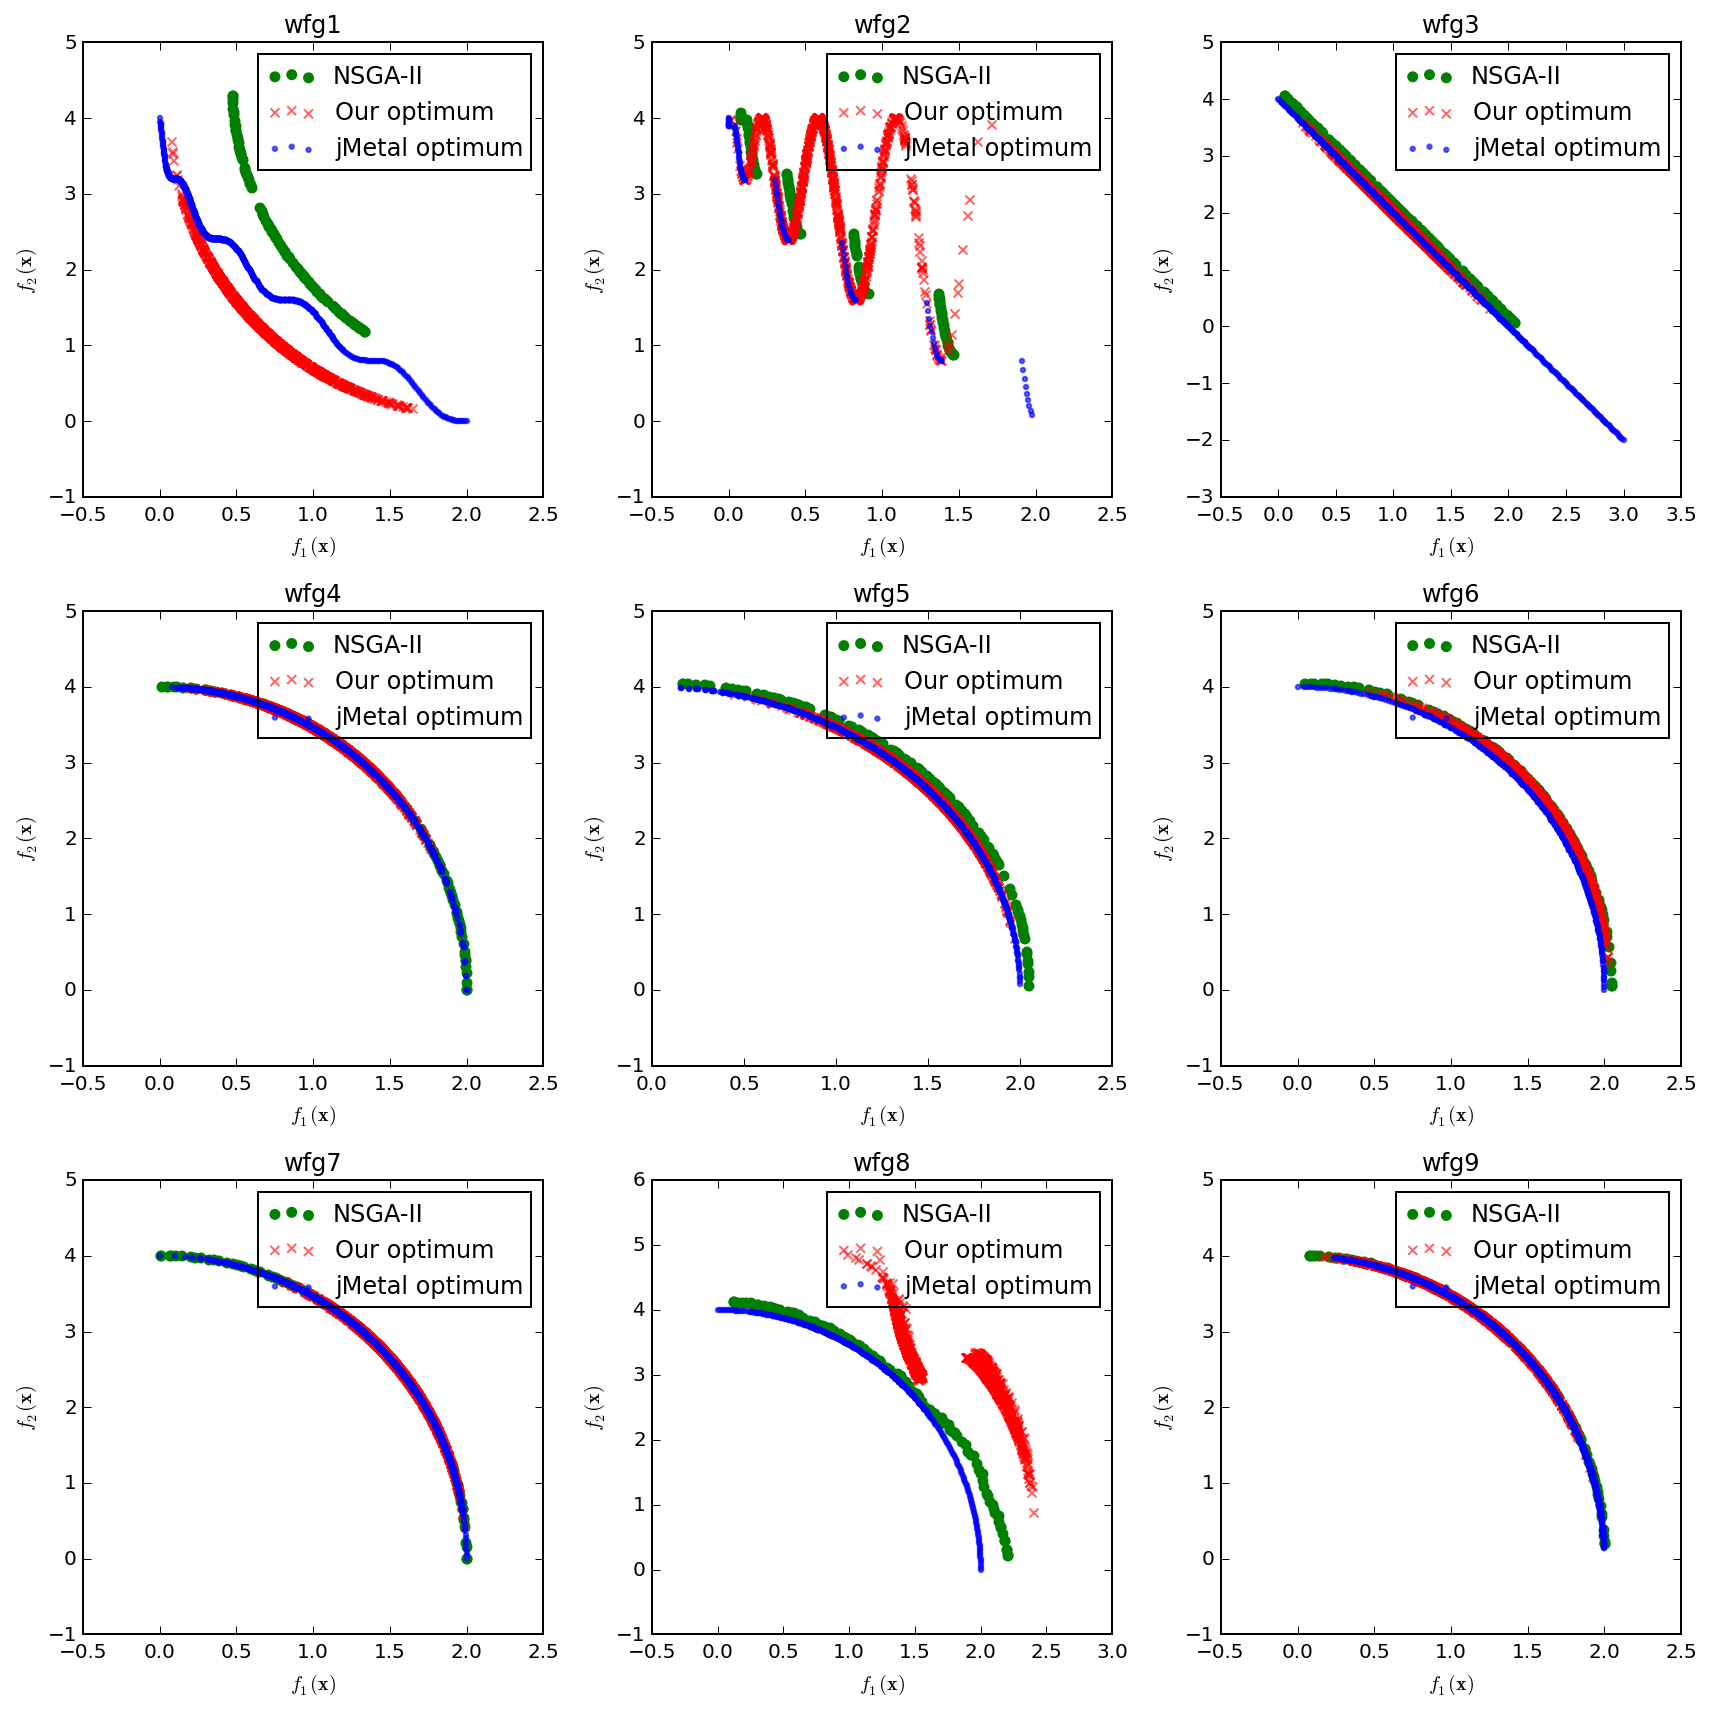

In [19]:
plt.figure(figsize=(4*(len(problems)//3),4*3))
for i, problem_name in enumerate(sorted(results)):
    ax = plt.subplot(len(problems)//3, 3, i+1)
    par = [ind.fitness.values for ind in results[problem_name]]
    df = pd.DataFrame(par)
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, label='NSGA-II', 
               marker='o', color='g')
    
    f, (bound_low, bound_high), sol_f = problems[problem_name](distance, position, num_objs)
    
    opt = [f(sol_f()) for _ in range(1000)]
    df = pd.DataFrame(data=opt)
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, marker='x',color='r',
               alpha=0.6, label='Our optimum')
    
    jm = pd.read_table('WFG.2D' + os.sep+ 'WFG'+ str(i+1)+'.2D.pf', sep=' ', header=None).dropna(axis=1)
    if i==1:
        jm = pd.read_table('WFG.2D' + os.sep+ 'WFG'+ str(i+1)+'.2D.pf', sep='\t', header=None).dropna(axis=1)
    
    ax.scatter(jm[jm.columns[0]].values, jm[jm.columns[1]].values, marker='.', 
               color='b', alpha=0.6, label='jMetal optimum')
    
    plt.legend()
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$')
    plt.title(problem_name)
    
plt.tight_layout()

# Three-objective problem

In [20]:
num_objs = 3

In [21]:
for problem_name in sorted(problems):
    f, _, _ = problems[problem_name](distance, position, num_objs)
    print(problem_name, f((np.random.rand(24))))

wfg1 [1.0011446295075124, 4.5258499458825741, 1.013784954581612]
wfg2 [0.6343361498311858, 0.80307921196783716, 5.5675840059128836]
wfg3 [0.74503432940081815, 1.2306797680028336, 5.5192406033116805]
wfg4 [1.7956007750313079, 1.4252525972662924, 5.9818717099058238]
wfg5 [0.55541023964938652, 2.4559268003122408, 4.7563997490455989]
wfg6 [0.12573068109945959, 1.4270411137667713, 5.6690855863912448]
wfg7 [2.854435761994611, 1.8716848283160914, 1.9211961688409709]
wfg8 [0.6585684158527817, 2.3396926762568784, 5.7440865722236545]
wfg9 [0.6023360675887508, 1.7462828078033525, 5.82144716318446]


Again, comparing with jMetal Pareto fronts.

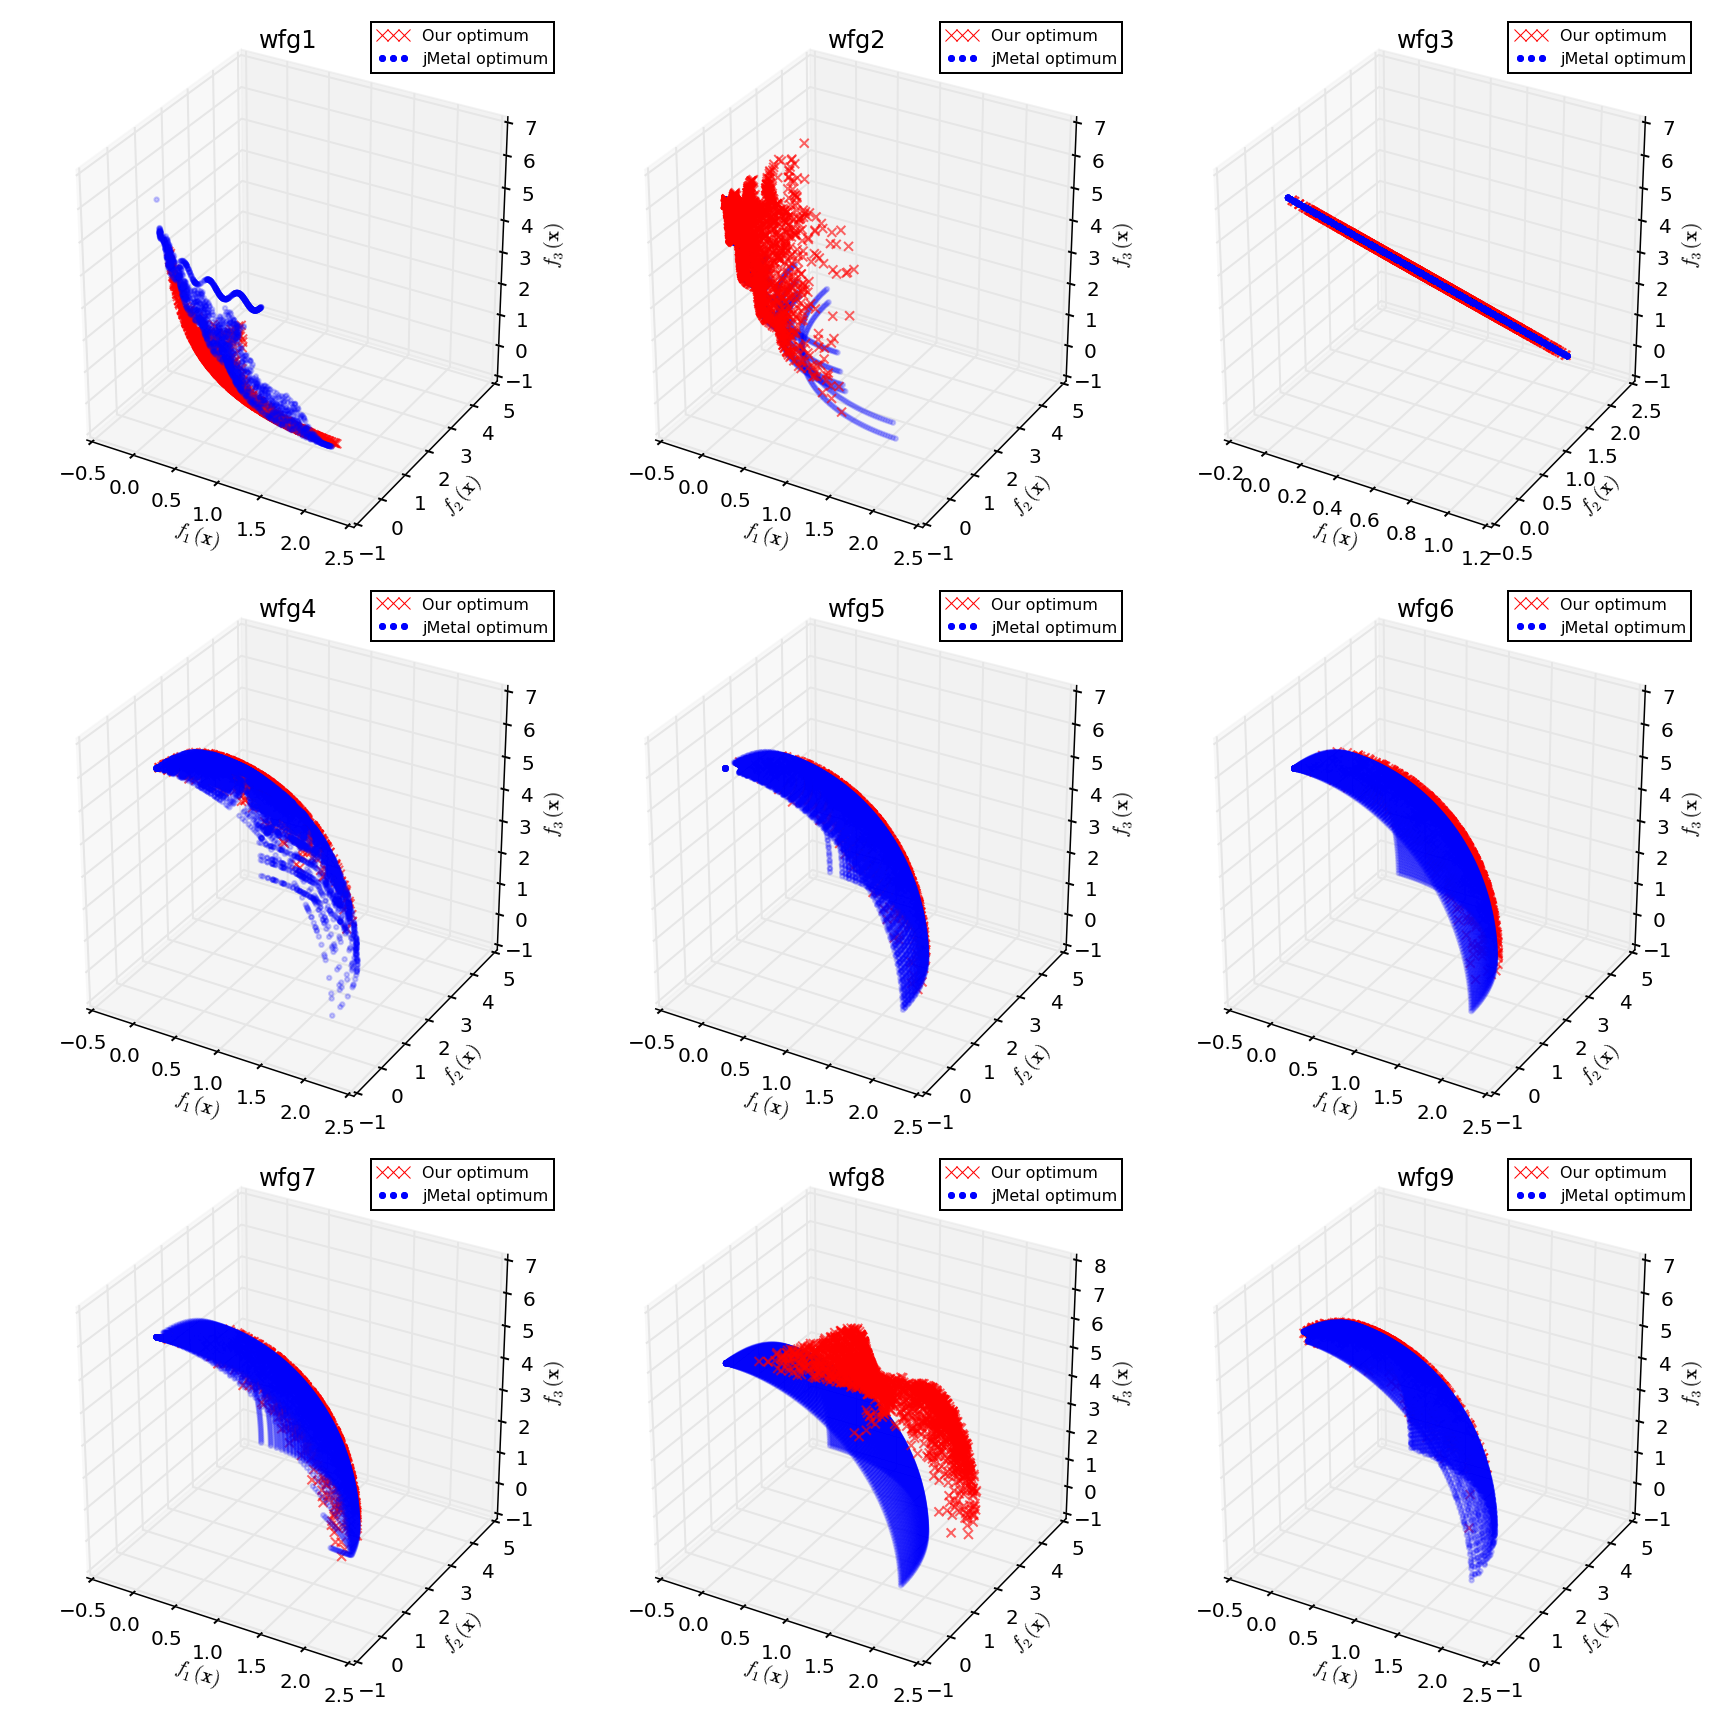

In [22]:
fig = plt.figure(figsize=(4*(len(problems)//3),4*3))
for i, problem_name in enumerate(sorted(problems)):
    ax = fig.add_subplot(len(problems)//3,3,i+1, projection='3d')
    
    f, (bound_low, bound_high), sol_f = problems[problem_name](distance, position, 3)
    
    opt = [f(sol_f()) for _ in range(2000)]

    df = pd.DataFrame(opt)
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, df[df.columns[2]].values, 
               marker='x', color='r', label='Optimum sample', alpha=0.6)
    
    jm = pd.read_table('WFG.3D' + os.sep+ 'WFG'+ str(i+1)+'.3D.pf', sep=' ', header=None).dropna(axis=1)
    
    ax.scatter(jm[jm.columns[0]].values, jm[jm.columns[1]].values,jm[jm.columns[2]].values, marker='.', 
               color='b', alpha=0.2, label='jMetal optimum')
    
    scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'x')
    scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = '.')
    ax.legend([scatter2_proxy,scatter3_proxy], ['Our optimum', 'jMetal optimum'], numpoints = 3,fontsize=8)
   
    ax.set_xlabel('$f_1(\mathbf{x})$')
    ax.set_ylabel('$f_2(\mathbf{x})$')
    ax.set_zlabel('$f_3(\mathbf{x})$')
    plt.title(problem_name)
    
plt.tight_layout()

In [23]:
creator.create("FitnessMin3D", base.Fitness, weights=(-1.,-1.,-1.))
creator.create("Individual3D", array.array, typecode='d',fitness=creator.FitnessMin3D)

In [24]:
def nsga_ii_3d(toolbox):
    
    toolbox.register("attr_float", uniform, 
                     toolbox.bounds_low, toolbox.bounds_high,
                     num_vars)
    toolbox.register("individual", tools.initIterate, creator.Individual3D, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, 
                     low=toolbox.bounds_low, up=toolbox.bounds_high, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, 
                     low=toolbox.bounds_low, up=toolbox.bounds_high, eta=20.0, indpb=1.0/num_vars)
    toolbox.register("select", tools.selNSGA2)
    
    toolbox.pop_size = 100
    toolbox.max_gen = 1000
    toolbox.mut_prob = 0.1
    
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    
    return algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, stats=None,
                                     ngen=toolbox.max_gen,verbose=False)

In [25]:
def run_nsga_ii_3d_on_problem(problem_name):
    f, (bounds_low, bounds_high), sol_f = problems[problem_name](distance, position, 3)
    
    toolbox = base.Toolbox()
    toolbox.register('evaluate', f)
    toolbox.bounds_low = bounds_low
    toolbox.bounds_high = bounds_high
    
    res,_ = nsga_ii_3d(toolbox)
    
    return res, problem_name

Run NSGA-II for every problem, now with 3 objectives. We are going to use all the CPU cores to save some time.

In [26]:
%%time
from multiprocessing import Pool
result_pairs = Pool().map(run_nsga_ii_3d_on_problem, problems)

CPU times: user 584 ms, sys: 196 ms, total: 780 ms
Wall time: 8min 10s


In [27]:
results_3d = {name: data for data, name in result_pairs}

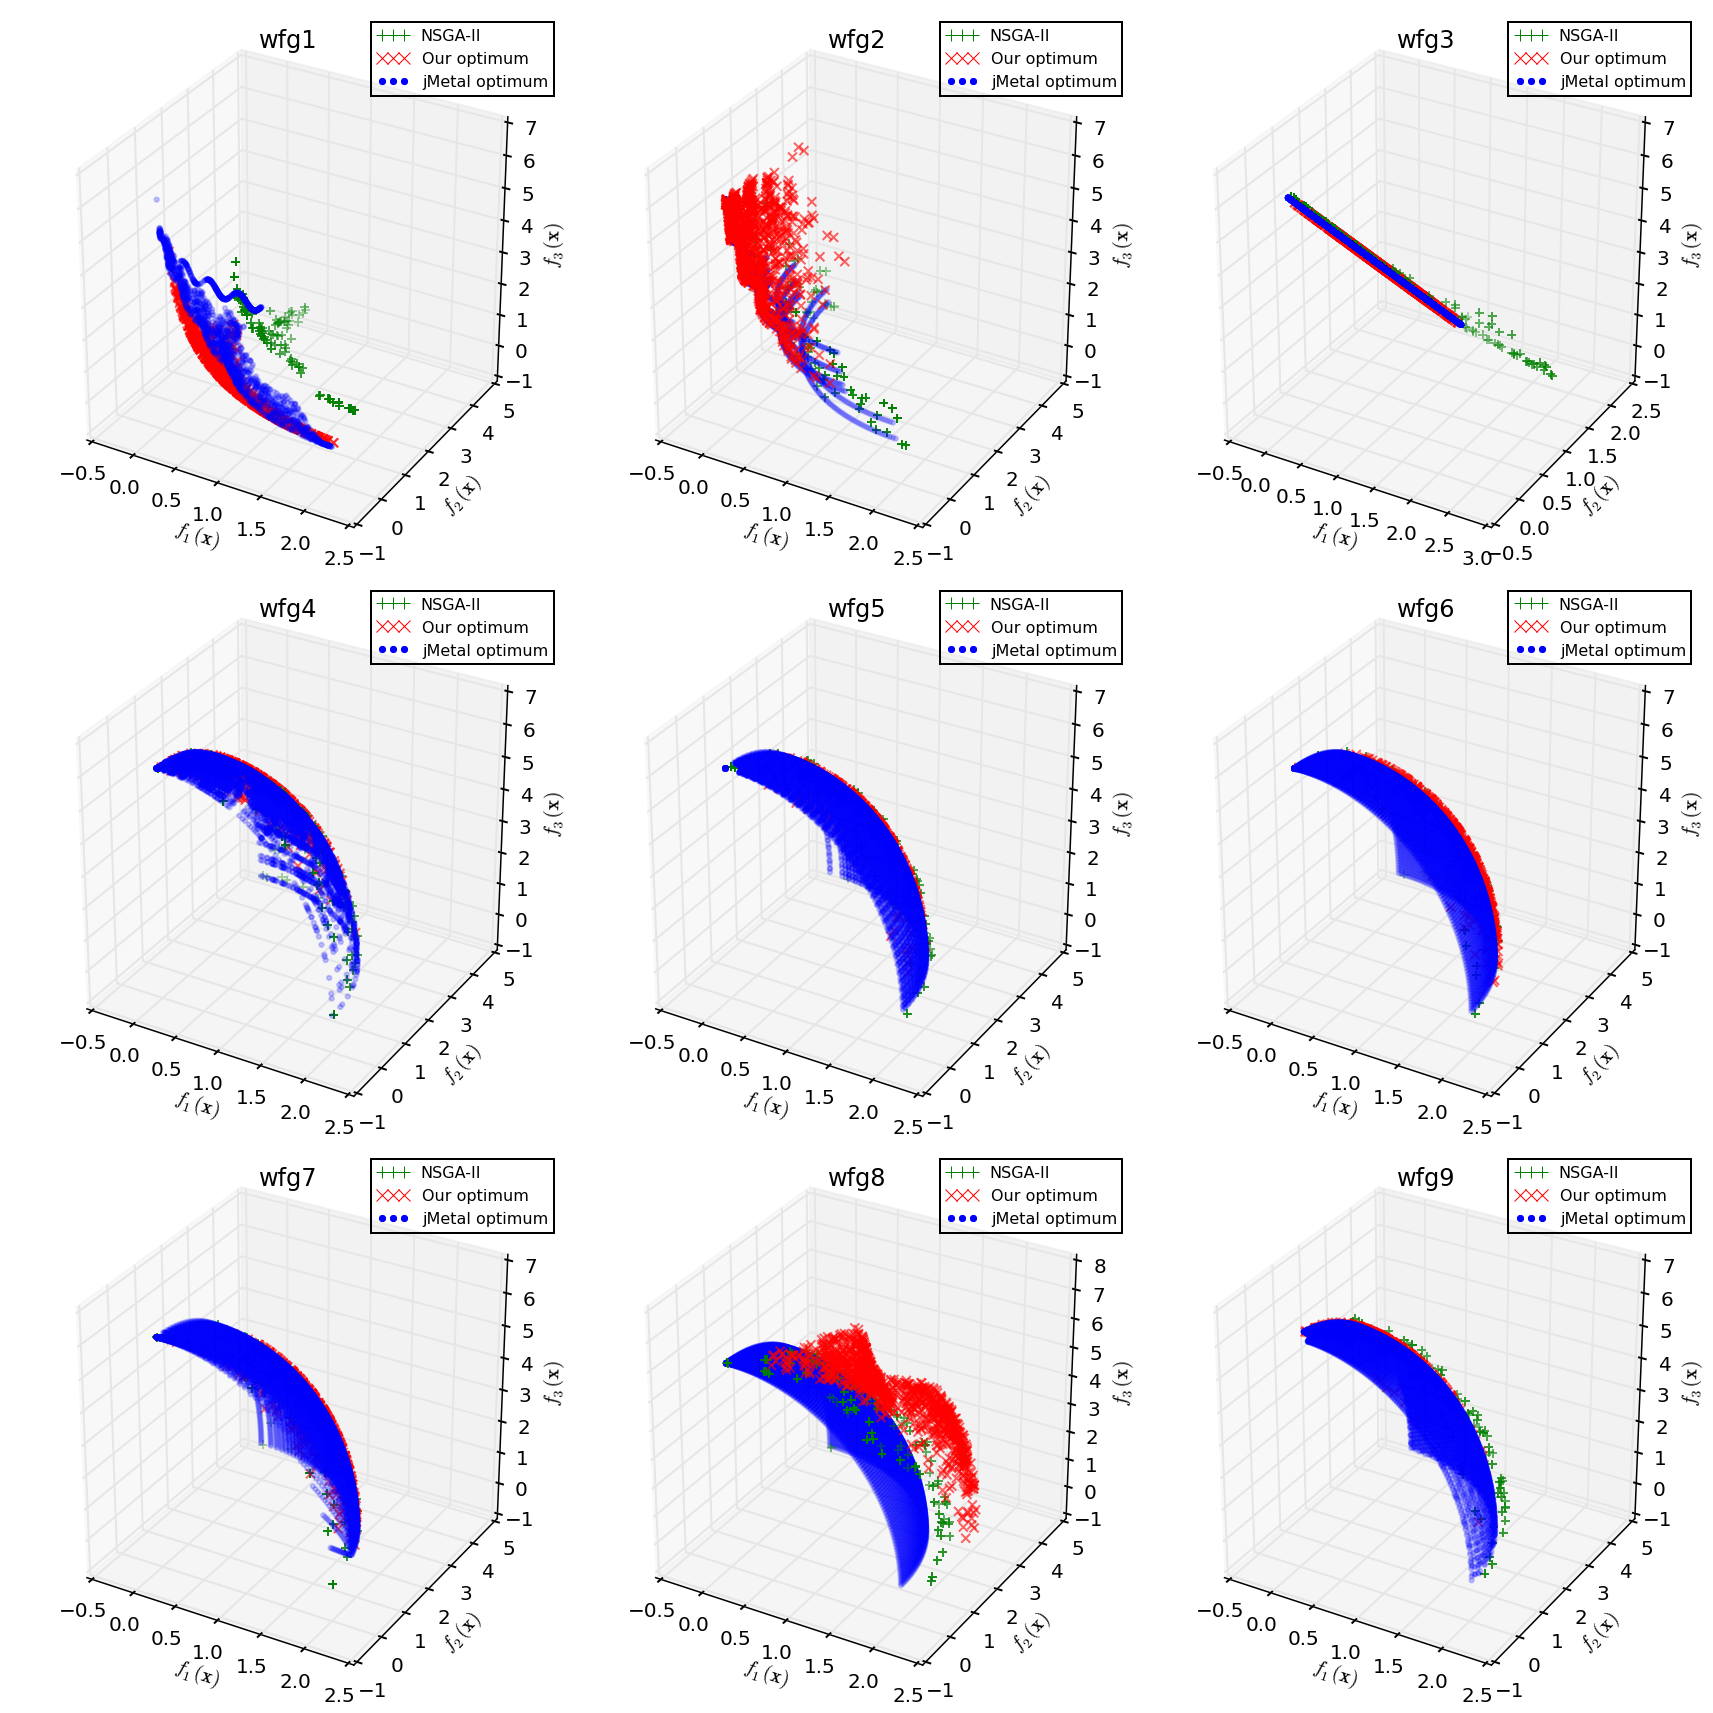

In [28]:
fig = plt.figure(figsize=(4*(len(problems)//3),4*3))
for i, problem_name in enumerate(sorted(results_3d)):
    ax = fig.add_subplot(len(problems)//3,3,i+1, projection='3d')
    par = [ind.fitness.values for ind in results_3d[problem_name]]
    df = pd.DataFrame(par)
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, df[df.columns[2]].values, 
               marker='+', color='g', label='NSGA-II')
    
    f, (bound_low, bound_high), sol_f = problems[problem_name](distance, position, 3)
    
    opt = [f(sol_f()) for _ in range(1000)]

    df = pd.DataFrame(opt)
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, df[df.columns[2]].values, 
               marker='x', color='r', label='Our optimum', alpha=0.6)
    
    jm = pd.read_table('WFG.3D' + os.sep+ 'WFG'+ str(i+1)+'.3D.pf', sep=' ', header=None).dropna(axis=1)
    
    ax.scatter(jm[jm.columns[0]].values, jm[jm.columns[1]].values,jm[jm.columns[2]].values, marker='.', 
               color='b', alpha=0.2, label='jMetal optimum')
    
    scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = '+')
    scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'x')
    scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = '.')
    ax.legend([scatter1_proxy, scatter2_proxy,scatter3_proxy], ['NSGA-II', 'Our optimum', 'jMetal optimum'],
               numpoints = 3,fontsize=8)
    
    ax.set_xlabel('$f_1(\mathbf{x})$')
    ax.set_ylabel('$f_2(\mathbf{x})$')
    ax.set_zlabel('$f_3(\mathbf{x})$')
    plt.title(problem_name)
    
plt.tight_layout()

Another reference of how the fronts should look like:

<table>
<tr>
<td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg1b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg2b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg3b.jpg'/>
</td>
</tr>
<tr><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg4b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg5b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg6b.jpg'/>
</tr>
<tr>
<td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg7b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg8b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg9b.jpg'/>
</td>
</tr>
</table>